In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
train_set = pd.read_csv('dataset/TrainingSet.csv')
test_set = pd.read_csv('dataset/TestingSet.csv')
valid_set = pd.read_csv('dataset/ValidationSet.csv')

print(train_set.shape)
print(test_set.shape)
print(valid_set.shape)

train = list(train_set.ErrorCount)
test = list(test_set.ErrorCount)
valid = list(valid_set.ErrorCount)

train_error_date = list(train_set.DateTime)
test_error_date = list(test_set.DateTime)
valid_error_date = list(valid_set.DateTime)

train_set.head(5)

(1008, 3)
(288, 3)
(912, 3)


,Unnamed: 0,DateTime,ErrorCount
0,0,0613-00~01,6537
1,1,0613-01~02,4851
2,2,0613-02~03,3699
3,3,0613-03~04,3085
4,4,0613-04~05,2666


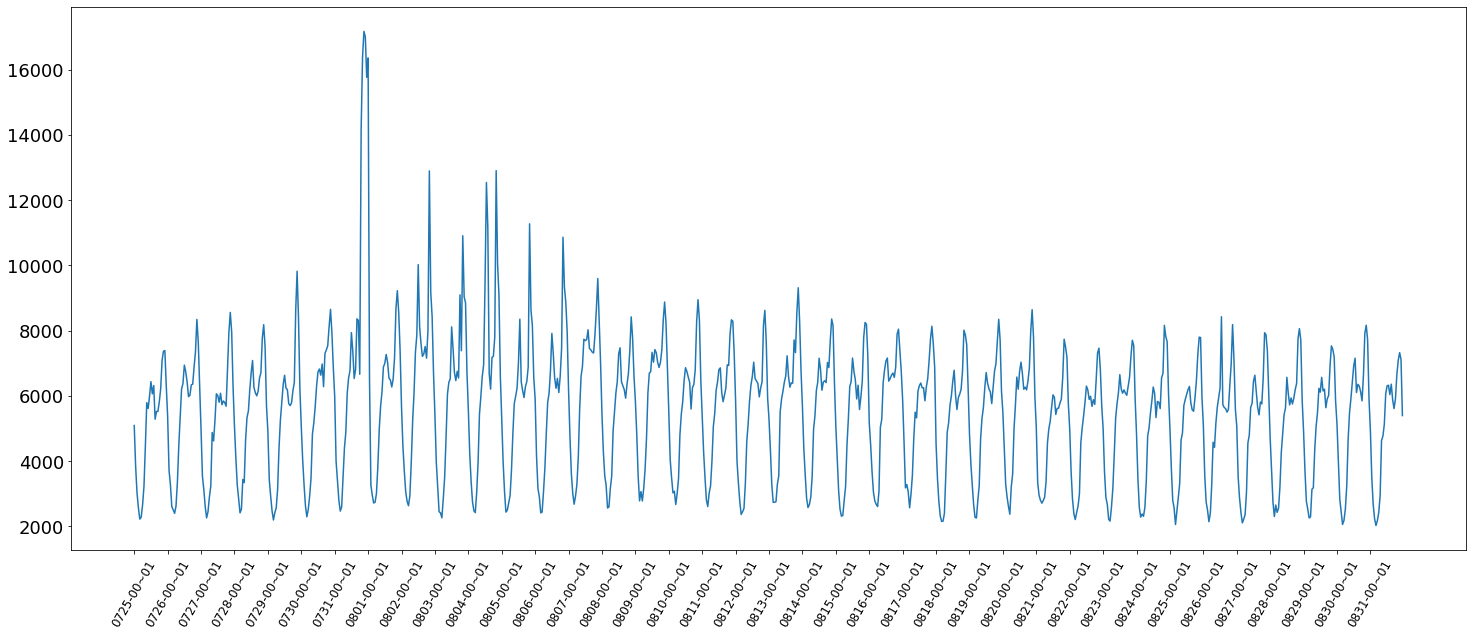

In [5]:
%matplotlib inline

plt.rcParams['figure.figsize'] = [25,10]
fig = plt.figure()
plt.plot(valid_error_date, valid)
plt.xticks(valid_error_date[::24], fontsize=12, rotation=60)
plt.yticks(fontsize=18)
plt.show()

In [17]:
from statsmodels.tsa.stattools import adfuller
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return diff

X = train
# difference data
# stationary = difference(X)
# check if stationary
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.122240
p-value: 0.000890
Critical Values:
	1%: -3.437
	5%: -2.864
	10%: -2.568


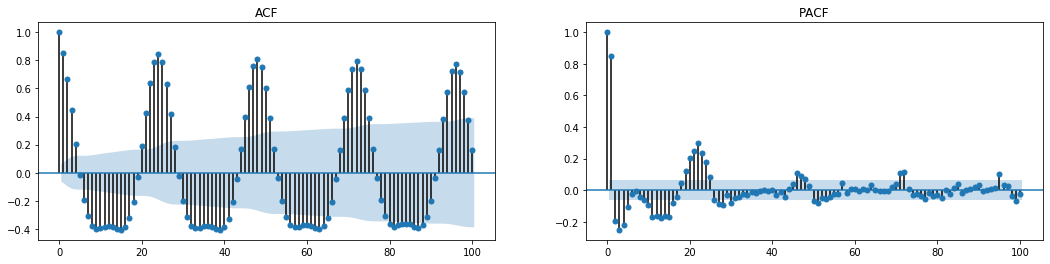

In [42]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def draw_acf_pacf(ts, lags):
    f = plt.figure(facecolor='white', figsize=(18,4))
    ax1 = f.add_subplot(121)
    plot_acf(ts, lags=lags, ax=ax1, title='ACF')
    ax2 = f.add_subplot(122)
    plot_pacf(ts, lags=lags, ax=ax2, title='PACF')
    plt.show
    
draw_acf_pacf(train, lags=100)

------------p = 24 | d = 0 | q = 0-----------


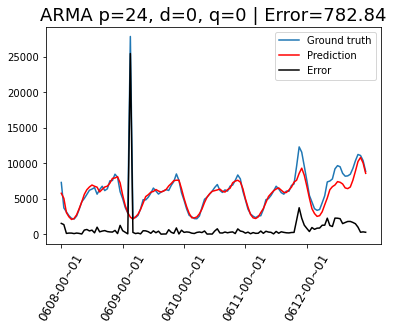

In [6]:
## from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm
import itertools

# p_list = [24, 48, 72, 96, 120, 144, 168]
p_list = [24]
d_list = [0]
q_list = [0]
pdq_list = list(itertools.product(p_list, d_list, q_list)) 

for pdq in pdq_list:
    p, d, q = pdq[0], pdq[1], pdq[2]
    predict = []
    test_mse = []

    print(f"------------p = {p} | d = {d} | q = {q}-----------")
    np.random.seed(0)
    
    model = SARIMAX(train, order=pdq, trend='c', enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit()
    start = 168 # actual is p
    model_fit = model_fit.append(test[0:start])
    
    for t in range(start, len(test)):
        output = model_fit.forecast()

        pred = output[0]
        truth = test[t]
        
        loss = abs(pred - truth)
        predict.append(pred)
        test_mse.append(loss)

        if (loss < 5000):
            model_fit = model_fit.append([truth])
        else:
            model_fit = model_fit.append([pred])

    plt.plot(test_error_date[start:], test[start:], label='Ground truth')
    plt.plot(test_error_date[start:], predict, color='red', label='Prediction')
    plt.plot(test_error_date[start:], test_mse, color='black', label='Error')
    plt.xticks(test_error_date[start:][::24], fontsize=12, rotation = 60)
    plt.legend(loc='best')
    plt.title(f'ARMA p={p}, d={d}, q={q} | Error={np.asarray(test_mse).mean():.02f}',fontsize=18)
    plt.show()
#     plt.savefig(f"./fig/ARMA_p_{p}-d_{d}-q_{q}.png")
#     plt.close()